# Exploring and Visualizing Data, Part II

We learn from [the iTunes search API documentation](https://affiliate.itunes.apple.com/resources/documentation/itunes-store-web-service-search-api/) that we can search all kinds of things in iTunes, without needing to authenticate (not that authentication is that difficult, really). For instance, we can search movies with the key `media` and the value `movie`. We need to provide our search term using the key `term`. The default number of results is 50, but let's try to get as many as we can (200), by setting `limit` to 200. 

Let's say our research question is: "how many movie and TV adaptations are there for Shakespeare plays?" We can search for the names of movies in the iTunes music library. 

**Warning**: Apple tells us that we can't make more than 20 requests per minute. That sounds reasonable, but it's also something we should be aware of. 

In [79]:
import requests
import json
import pandas
from collections import Counter
%matplotlib inline

First, let's just get the songs matching one play.

In [3]:
query = "Hamlet"
params = {"media": "movie", "term": query, "limit": 200}
response = requests.get("https://itunes.apple.com/search", params=params)

In [4]:
response.ok

True

In [5]:
parsedJSON = json.loads(response.text)

In [6]:
parsedJSON.keys()

dict_keys(['resultCount', 'results'])

In [7]:
parsedJSON['resultCount']

13

In [8]:
parsedJSON['results'][0].keys()

dict_keys(['wrapperType', 'kind', 'trackId', 'artistName', 'trackName', 'trackCensoredName', 'trackViewUrl', 'previewUrl', 'artworkUrl30', 'artworkUrl60', 'artworkUrl100', 'collectionPrice', 'trackPrice', 'trackRentalPrice', 'collectionHdPrice', 'trackHdPrice', 'trackHdRentalPrice', 'releaseDate', 'collectionExplicitness', 'trackExplicitness', 'trackTimeMillis', 'country', 'currency', 'primaryGenreName', 'contentAdvisoryRating', 'shortDescription', 'longDescription'])

In [70]:
for track in parsedJSON['results']: 
    print(track['artistName'] + ": " + track['trackName'] + " -- " + track['primaryGenreName'])

Laurence Olivier: Hamlet -- Drama
Kenneth Branagh: Hamlet (1996) -- Drama
Michael Almereyda: Hamlet (2000) -- Drama
Tony Richardson: Hamlet -- Drama
Franco Zeffirelli: Hamlet -- Drama
Andrew Fleming: Hamlet 2 -- Comedy
Greg Watkins: This is Hamlet -- Documentary
Antoni Cimolino & Shelagh O'Brien: Hamlet -- Drama
Sarah Frankcom & Margaret Williams: Hamlet (2015) -- Drama
Kevin Murphy: Mystery Science Theater 3000: Hamlet -- Comedy
Matthew Young & Jared Young: Hamlet & Hutch -- Kids & Family
Walker Haynes: Hamlet's Ghost -- Kids & Family
John Murlowski: Zombie Hamlet -- Comedy


Some of those are a little of a stretch (_Zombie Hamlet_?), but we'll take it. Now let's do that same lookup, but for a bunch of Shakespeare play titles. First, define the titles we'll be using: 

In [60]:
shakesPlays = ["Hamlet", "Othello", "Macbeth", "King Lear", "Midsummer Night's Dream", "Much Ado About Nothing", "Merchant of Venice", "Romeo and Juliet"]

Next, write a `for` loop that goes through each of these, 

In [61]:
shakesMovies = {}
for query in shakesPlays:
    params = {"media": "movie", "term": query, "limit": 200}
    response = requests.get("https://itunes.apple.com/search", params=params)
    if response.ok: 
        parsed = json.loads(response.text)
        if 'resultCount' in parsed: 
            shakesMovies[query] = parsed['resultCount']

In [62]:
shakesMovies

{'Hamlet': 13,
 'King Lear': 1,
 'Macbeth': 7,
 'Merchant of Venice': 1,
 "Midsummer Night's Dream": 3,
 'Much Ado About Nothing': 2,
 'Othello': 1,
 'Romeo and Juliet': 11}

In [63]:
shakesTV = {}
for query in shakesPlays:
    params = {"media": "tvShow", "term": query, "limit": 200}
    response = requests.get("https://itunes.apple.com/search", params=params)
    if response.ok: 
        parsed = json.loads(response.text)
        if 'resultCount' in parsed: 
            shakesTV[query] = parsed['resultCount']

In [64]:
shakesTV

{'Hamlet': 5,
 'King Lear': 2,
 'Macbeth': 5,
 'Merchant of Venice': 0,
 "Midsummer Night's Dream": 6,
 'Much Ado About Nothing': 3,
 'Othello': 1,
 'Romeo and Juliet': 8}

Now, since we have multi-column data, we need to put this into a Pandas `DataFrame` object. It's like a `Series` object, but for multi-column data, our two columns here being movies and TV. We'll pass a list of our two dictionaries to `DataFrame`, and we'll also give it the option `index`, which will just act as labels. 

In [65]:
shakespeareAdaptations = pandas.DataFrame([shakesMovies, shakesTV], index=['movies', 'tv'])
shakespeareAdaptations

,Hamlet,King Lear,Macbeth,Merchant of Venice,Midsummer Night's Dream,Much Ado About Nothing,Othello,Romeo and Juliet
movies,13,1,7,1,3,2,1,11
tv,5,2,5,0,6,3,1,8


That looks great, only our colums and rows are mixed up. We can transpose our data, though, using the `.T` method: 

In [68]:
shakespeareAdaptationsT = shakespeareAdaptations.T
shakespeareAdaptationsT

,movies,tv
Hamlet,13,5
King Lear,1,2
Macbeth,7,5
Merchant of Venice,1,0
Midsummer Night's Dream,3,6
Much Ado About Nothing,2,3
Othello,1,1
Romeo and Juliet,11,8


That's better. Now let's plot it: 

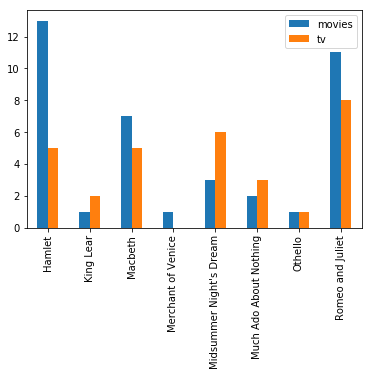

In [69]:
shakespeareAdaptationsT.plot(kind="bar")

Now how about we do something with genres? We'll create a dictionary where the key will be movie titles, and the value will be a list of movie genres, i.e. `{"Hamlet": ["Drama", "Drama", "Comedy"]}`. First, we can initialize this dictionary with a bunch of empty lists: 

In [74]:
shakesMovieGenres = {playTitle: [] for playTitle in shakesPlays}
shakesMovieGenres

{'Hamlet': [],
 'King Lear': [],
 'Macbeth': [],
 'Merchant of Venice': [],
 "Midsummer Night's Dream": [],
 'Much Ado About Nothing': [],
 'Othello': [],
 'Romeo and Juliet': []}

Now we'll write a `for` loop where we can go through each play, and another for loop inside that where we go through that play's results. We'll append that result's genre to our blank list: 

In [80]:
for query in shakesPlays:
    params = {"media": "movie", "term": query, "limit": 200}
    response = requests.get("https://itunes.apple.com/search", params=params)
    if response.ok: 
        parsed = json.loads(response.text)
        for result in parsed['results']: 
            shakesMovieGenres[query].append(result['primaryGenreName'])

In [89]:
shakesMovieGenres

{'Hamlet': ['Drama',
  'Drama',
  'Drama',
  'Drama',
  'Drama',
  'Comedy',
  'Documentary',
  'Drama',
  'Drama',
  'Comedy',
  'Kids & Family',
  'Kids & Family',
  'Comedy',
  'Drama',
  'Drama',
  'Drama',
  'Drama',
  'Drama',
  'Comedy',
  'Documentary',
  'Drama',
  'Drama',
  'Comedy',
  'Kids & Family',
  'Kids & Family',
  'Comedy'],
 'King Lear': ['Drama', 'Drama'],
 'Macbeth': ['Drama',
  'Drama',
  'Classics',
  'Drama',
  'Drama',
  'Concert Films',
  'Comedy',
  'Drama',
  'Drama',
  'Classics',
  'Drama',
  'Drama',
  'Concert Films',
  'Comedy'],
 'Merchant of Venice': ['Drama', 'Drama'],
 "Midsummer Night's Dream": ['Comedy',
  'Drama',
  'Comedy',
  'Comedy',
  'Drama',
  'Comedy'],
 'Much Ado About Nothing': ['Comedy', 'Comedy', 'Comedy', 'Comedy'],
 'Othello': ['Drama', 'Drama'],
 'Romeo and Juliet': ['Romance',
  'Romance',
  'Drama',
  'Drama',
  'Romance',
  'Drama',
  'Musicals',
  'Concert Films',
  'Comedy',
  'Comedy',
  'Concert Films',
  'Romance',
  'Rom

In [90]:
shakesMovieGenres["Hamlet"]

['Drama',
 'Drama',
 'Drama',
 'Drama',
 'Drama',
 'Comedy',
 'Documentary',
 'Drama',
 'Drama',
 'Comedy',
 'Kids & Family',
 'Kids & Family',
 'Comedy',
 'Drama',
 'Drama',
 'Drama',
 'Drama',
 'Drama',
 'Comedy',
 'Documentary',
 'Drama',
 'Drama',
 'Comedy',
 'Kids & Family',
 'Kids & Family',
 'Comedy']

We can count these up the long way: 

In [93]:
hamletGenreCounts = {}
for genre in shakesMovieGenres["Hamlet"]: 
    # If it's already in the dictionary
    if genre in hamletGenreCounts:
        hamletGenreCounts[genre] = hamletGenreCounts[genre] + 1
    # If it's not there yet
    else:
        hamletGenreCounts[genre] = 1
hamletGenreCounts

{'Comedy': 6, 'Documentary': 2, 'Drama': 14, 'Kids & Family': 4}

Or we can actually just use the `Counter` class from the `collections` library.

In [91]:
Counter(shakesMovieGenres["Hamlet"])

Counter({'Comedy': 6, 'Documentary': 2, 'Drama': 14, 'Kids & Family': 4})